# Fault Classification

This project deals with using machine learning to classify fault signatures on the basis of high-resolution (20 kHz) waveform measurements recorded by digital fault relays (DFRs). Your challenge is to relate time series measurements with metadata collected about what caused the fault. Accurately predicting the cause of a fault based on the time series data could reduce the amount of labor involved in diagnosing certain types of issues on the grid. These algorithms could have useful applications for preventative maintenance.

This challenge uses a public dataset released by EPRI to support advancements in machine learning for fault recognition, and are available for download [here](https://pqmon.epri.com/see_all.html).

In [34]:
import btrdb
import yaml
import os
from matplotlib import pyplot as plt

In [5]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
db = btrdb.connect(config['connection']['api_url'], config['connection']['api_key'])

In [10]:
collection = 'PQdata/epri'
streams = db.streams_in_collection(collection)

## Event data

Within the collection "PQdata/epri", there are 254 fault events. Each event is it's own collection (PQdata/epri/eventXXXX). Within each event are time series measurements for 3-phase voltage, 3-phase current, and neutral current.

In [13]:
# get a list of unique events within the "PQdata/epri" collection
events = list(set([s.collection.split('/')[-1] for s in streams]))

print(events[:5])
print(len(events))

['event2789', 'event0960', 'event4083', 'event3934', 'event2890']
254


In [49]:
event = events[0]
streams   = db.streams_in_collection(os.path.join(collection, event))
streamset = db.streams(*[s.uuid for s in streams])

start, _ = streams[0].earliest()
end, _ = streams[0].latest()

data = streamset.filter(start.time, end.time).to_dataframe()
data = data.reset_index()

In [50]:
data.head()

,time,PQdata/epri/event2789/Vb,PQdata/epri/event2789/Vc,PQdata/epri/event2789/Ia,PQdata/epri/event2789/Ib,PQdata/epri/event2789/Ic,PQdata/epri/event2789/In,PQdata/epri/event2789/Va
0,1122487707918000000,-9920.083008,9938.632812,17.766720,-2821.294922,2927.370605,5.91223,271.555969
1,1122487707918130176,-10199.030273,9676.629883,159.900467,-2892.419922,2838.662354,-5.91223,797.148132
2,1122487707918260352,-10425.675781,9414.626953,313.878723,-2963.545166,2744.040283,0.00000,1331.500122
3,1122487707918390528,-10617.452148,9135.157227,461.934692,-3016.888916,2637.590332,0.00000,1900.891724
4,1122487707918520704,-10739.492188,8855.688477,609.990723,-3070.232666,2519.312744,-5.91223,2496.562744


In [57]:
data = data.rename(columns=dict(zip(data.keys(), [key.split('/')[-1] for key in data.keys()])))
data = data.reset_index()

voltage_cols = [key for key in data.keys() if 'V' in key]
current_cols = [key for key in data.keys() if 'I' in key]

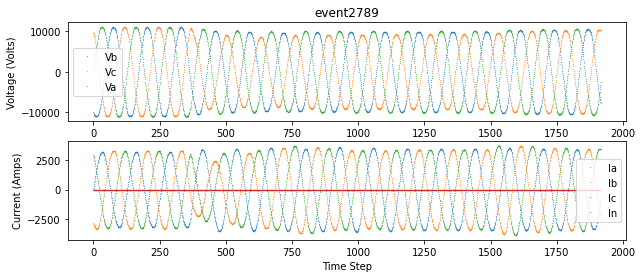

In [58]:
fig, ax = plt.subplots(figsize=(10,4), nrows=2)

data[voltage_cols].plot(ax=ax[0], ls=' ', marker='.', ms=0.5)
data[current_cols].plot(ax=ax[1], ls=' ', marker='.', ms=0.5)

ax[0].set_ylabel('Voltage (Volts)')
ax[1].set_ylabel('Current (Amps)')

ax[0].set_title(event)
ax[1].set_xlabel('Time Step')
plt.show()

## Metadata

Each event includes metadata (or "annotations") that provide a little more context about what was happening on the grid at the time the fault occurred. In some cases --- as with "tree" or "animal" --- it may take considerable effort to determine the cause.

In [46]:
streams[0].annotations()

({'Cause': 'Lightning',
  'SiteName': 'Site0010',
  'Phase': '1',
  'IsolationEquipmentCode': 'Breaker',
  'EventId': '2789',
  'FeederId': 'Unknown',
  'FailedEquipmentCode': 'Unknown',
  'Details': 'Lightning on the Line',
  'Weather': 'Unknown',
  'DataSource': 'https://pqmon.epri.com/see_all.html',
  'EventTime': '2005-07-27 18:08:27.918000'},
 2)

## Coding Challenge

Your challenge is to explore machine learning algorithms for clustering and classifying events to see if you can accurately predict the cause of a fault given time series data from the event.